# Predicting IBM 1-min-time series
* DO NOT TOUCH THIS UNTIL THE STRATEGY THAT THESE MODELS SUGGEST IS SIMULATED
* It is possible to get (ocationally) a signal with around 1% recall and around 80% precision using a regularized logistic regression
* If we managed to do this on many stocks we would be able to build a reasonable strategy from there.
* Still need to simulate the strategy for many stocks. It might actually work
* Do some slides to show Jake
* What if we negate the target and study NPV instead: recall improves !
* Use naive Bayes: BernoulliNB out of the box is producing nice precision-recall curves
* What if we deal with class weights in the logistic regressions? class_weight

In [1]:
cd ~/Desktop/MyProjects/moneyManager/

/Users/lduque/Desktop/myProjects/moneyManager


In [2]:
class_weight={True:0.7, False:0.3}

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import GridSearchCV
from modeling.createTrainingDataSet import createTrainingDataSet, loadTimeSeries
from modeling.StockModel import generatePipeline
from modeling.sklearnUtilities import createTimeFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import random
pd.set_option('display.max_columns', None)

In [4]:
def plot_precision_recall_on_train_and_test(model, Xtrain, ytrain, Xtest, ytest):
    disp = plot_precision_recall_curve(model, Xtrain, ytrain)
    disp.ax_.set_xlim(0.0, 0.5);
    disp.ax_.set_ylim(0.4, 1.0);
    disp.ax_.set_title('precision - recall in train data set');


    disp = plot_precision_recall_curve(model, Xtest, ytest);
    disp.ax_.set_xlim(0.0, 0.5);
    disp.ax_.set_ylim(0.4, 1.0);
    disp.ax_.set_title('precision - recall in test data set');

In [5]:
startDay=datetime(2019,1,1)
endDay= datetime(2019,2,1)
df = createTrainingDataSet('IBM',  startDay=startDay, endDay=endDay, pastStart=10)
df = df[['consolidated', 'volume', 'target']]

In [6]:
df.head()

,consolidated,volume,target
date,,,
2019-01-02 14:31:00,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",True
2019-01-02 14:32:00,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",True
2019-01-02 14:33:00,"[nan, nan, nan, nan, nan, nan, nan, nan, 106.9...","[nan, nan, nan, nan, nan, nan, nan, nan, 85379...",True
2019-01-02 14:34:00,"[nan, nan, nan, nan, nan, nan, nan, 106.9315, ...","[nan, nan, nan, nan, nan, nan, nan, 85379.0, 1...",True
2019-01-02 14:35:00,"[nan, nan, nan, nan, nan, nan, 106.9315, 107.2...","[nan, nan, nan, nan, nan, nan, 85379.0, 12219....",True


In [7]:
df.shape

(8190, 3)

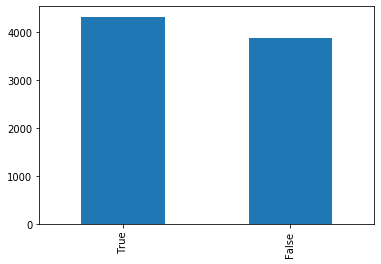

In [8]:
df.target.value_counts().plot.bar()

In [9]:
X = df.copy()
y = X.pop('target')

In [10]:
Xtrain, ytrain = X[:len(X)//2], y[:len(X)//2] 
Xtest, ytest = X[len(X)//2:], y[len(X)//2:]

# Debugging the pipeline
* So far we have 83 features

In [11]:
pipeline = generatePipeline()
pipeline.fit(Xtrain)
XtrainTrf = pipeline.transform(Xtrain)
XtestTrf = pipeline.transform(Xtest)
XtrainTrf.shape

/Users/lduque/Desktop/myProjects/moneyManager/venv-money/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/lduque/Desktop/myProjects/moneyManager/venv-money/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/lduque/Desktop/myProjects/moneyManager/venv-money/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


(4095, 63)

In [12]:
Xtrain.head()

,consolidated,volume
date,,
2019-01-02 14:31:00,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2019-01-02 14:32:00,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2019-01-02 14:33:00,"[nan, nan, nan, nan, nan, nan, nan, nan, 106.9...","[nan, nan, nan, nan, nan, nan, nan, nan, 85379..."
2019-01-02 14:34:00,"[nan, nan, nan, nan, nan, nan, nan, 106.9315, ...","[nan, nan, nan, nan, nan, nan, nan, 85379.0, 1..."
2019-01-02 14:35:00,"[nan, nan, nan, nan, nan, nan, 106.9315, 107.2...","[nan, nan, nan, nan, nan, nan, 85379.0, 12219...."


In [13]:
XtrainTrf.isna().sum()

consolidated_max          0
consolidated_argmax       0
consolidated_min          0
consolidated_argmin       0
consolidated_mean         0
                         ..
volumeDifference_last     0
volumeDifference_first    0
hour                      0
minute                    0
hourminute                0
Length: 63, dtype: int64

In [14]:
XtrainTrf.head()

,consolidated_max,consolidated_argmax,consolidated_min,consolidated_argmin,consolidated_mean,consolidated_std,consolidated_var,consolidated_median,consolidated_kurtosis,consolidated_skew,consolidated_numpos,consolidated_posvar,consolidated_numnan,consolidated_last,consolidated_first,volume_max,volume_argmax,volume_min,volume_argmin,volume_mean,volume_std,volume_var,volume_median,volume_kurtosis,volume_skew,volume_numpos,volume_posvar,volume_numnan,volume_last,volume_first,consolidatedDifference_max,consolidatedDifference_argmax,consolidatedDifference_min,consolidatedDifference_argmin,consolidatedDifference_mean,consolidatedDifference_std,consolidatedDifference_var,consolidatedDifference_median,consolidatedDifference_kurtosis,consolidatedDifference_skew,consolidatedDifference_numpos,consolidatedDifference_posvar,consolidatedDifference_numnan,consolidatedDifference_last,consolidatedDifference_first,volumeDifference_max,volumeDifference_argmax,volumeDifference_min,volumeDifference_argmin,volumeDifference_mean,volumeDifference_std,volumeDifference_var,volumeDifference_median,volumeDifference_kurtosis,volumeDifference_skew,volumeDifference_numpos,volumeDifference_posvar,volumeDifference_numnan,volumeDifference_last,volumeDifference_first,hour,minute,hourminute
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02 14:31:00,0.832025,0.0,0.829525,0.0,0.834304,0.058911,0.004731,0.83293,0.127969,0.466902,0.0,0.000000,1.0,0.021295,0.826192,0.057528,0.0,0.151695,0.0,0.101337,0.053244,0.004152,0.120835,0.202708,0.511589,0.0,0.000000,1.0,0.590499,0.038039,0.046515,0.0,0.832317,0.0,0.375181,0.057178,0.005121,0.590313,0.153408,0.459877,0.0,0.000604,1.0,0.266572,0.266572,0.048218,0.0,0.950324,0.0,0.506673,0.063274,0.005504,0.321381,0.19078,0.494124,0.000,0.002065,1.0,0.466735,0.466726,0.0,0.525424,0.000000
2019-01-02 14:32:00,0.832025,0.0,0.829525,0.0,0.834304,0.058911,0.004731,0.83293,0.127969,0.466902,0.1,0.029241,0.9,0.052057,0.826192,0.057528,0.0,0.151695,0.0,0.101337,0.053244,0.004152,0.120835,0.202708,0.511589,0.1,0.817773,0.9,0.084509,0.038039,0.046515,0.0,0.832317,0.0,0.375181,0.057178,0.005121,0.590313,0.153408,0.459877,0.1,0.000000,0.9,0.395530,0.266572,0.048218,0.0,0.950324,0.0,0.506673,0.063274,0.005504,0.321381,0.19078,0.494124,0.000,0.002065,0.9,0.140717,0.466726,0.0,0.542373,0.001495
2019-01-02 14:33:00,0.832025,0.0,0.829525,0.0,0.834304,0.058911,0.004731,0.83293,0.127969,0.466902,0.2,0.023930,0.8,0.049385,0.826192,0.057528,0.0,0.151695,0.0,0.101337,0.053244,0.004152,0.120835,0.202708,0.511589,0.2,0.819209,0.8,0.026835,0.038039,0.046515,0.0,0.832317,0.0,0.375181,0.057178,0.005121,0.590313,0.153408,0.459877,0.1,0.000000,0.8,0.254300,0.266572,0.048218,0.0,0.950324,0.0,0.506673,0.063274,0.005504,0.321381,0.19078,0.494124,0.000,0.002065,0.8,0.429508,0.466726,0.0,0.559322,0.002990
2019-01-02 14:34:00,0.832025,0.0,0.829525,0.0,0.834304,0.058911,0.004731,0.83293,0.127969,0.466902,0.3,0.026196,0.7,0.022047,0.826192,0.057528,0.0,0.151695,0.0,0.101337,0.053244,0.004152,0.120835,0.202708,0.511589,0.3,0.630571,0.7,0.151804,0.038039,0.046515,0.0,0.832317,0.0,0.375181,0.057178,0.005121,0.590313,0.153408,0.459877,0.1,0.000000,0.7,0.150104,0.266572,0.048218,0.0,0.950324,0.0,0.506673,0.063274,0.005504,0.321381,0.19078,0.494124,0.125,0.000000,0.7,0.547160,0.466726,0.0,0.576271,0.004484
2019-01-02 14:35:00,0.832025,0.0,0.829525,0.0,0.834304,0.058911,0.004731,0.83293,0.127969,0.466902,0.4,0.037810,0.6,0.007003,0.826192,0.057528,0.0,0.151695,0.0,0.101337,0.053244,0.004152,0.120835,0.202708,0.511589,0.4,0.550909,0.6,0.062668,0.038039,0.046515,0.0,0.832317,0.0,0.375181,0.057178,0.005121,0.590313,0.153408,0.459877,0.1,0.000000,0.6,0.202038,0.266572,0.048218,0.0,0.950324,0.0,0.506673,0.063274,0.005504,0.321381,0.19078,0.494124,0.125,0.000000,0.6,0.409241,0.466726,0.0,0.593220,0.005979


# No regularization
* Performance is not awesome
* Huge overfit: notice how different precision and recall curves are.

In [15]:
clf =LogisticRegression(penalty='none', max_iter=10000, class_weight=class_weight)
clf.fit(XtrainTrf, ytrain);  

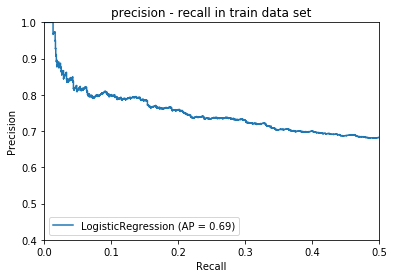

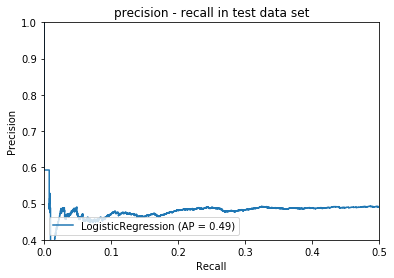

In [16]:
plot_precision_recall_on_train_and_test(clf, XtrainTrf, ytrain, XtestTrf, ytest)

# L1 regularization

In [17]:
C = 10**np.linspace(-4,1,50) 
grid_parameters = {
    'C': C,
    'class_weight': [class_weight],
    'penalty':['l1']
}

clf = GridSearchCV(LogisticRegression(solver='saga',max_iter=10000, multi_class='ovr', C=C), grid_parameters, scoring='average_precision', cv=2, return_train_score=True)
clf.fit(XtrainTrf, ytrain);  
test_scores = clf.cv_results_['mean_test_score']
train_scores = clf.cv_results_['mean_train_score']
ds = pd.DataFrame({'train_scores':train_scores, 'evaluation_scores':test_scores}, index=C)

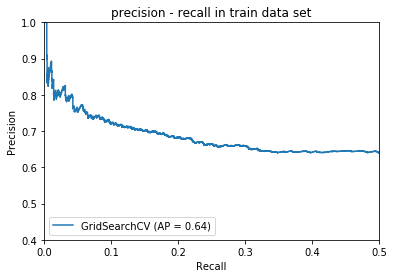

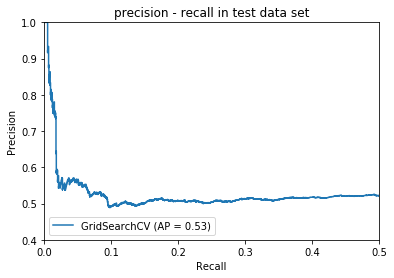

In [18]:
plot_precision_recall_on_train_and_test(clf, XtrainTrf, ytrain, XtestTrf, ytest)

0.6073210347214588
---
consolidatedDifference_numpos    1.209152
hour                             0.807137
volumeDifference_std             0.537427
consolidated_skew                0.499027
consolidated_last                0.318698
                                   ...   
consolidatedDifference_std       0.000000
consolidatedDifference_mean      0.000000
consolidatedDifference_max       0.000000
volume_first                     0.000000
consolidated_max                 0.000000
Length: 63, dtype: float64
---
LogisticRegression(C=0.3727593720314942, class_weight={False: 0.3, True: 0.7},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=10000, multi_class='ovr',
                   n_jobs=None, penalty='l1', random_state=None, solver='saga',
                   tol=0.0001, verbose=0, warm_start=False)


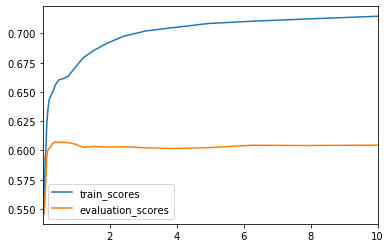

In [19]:
ds.plot()
print(ds.evaluation_scores.max())
print('---')
print(pd.Series(clf.best_estimator_.coef_[0], index=XtrainTrf.columns).abs().sort_values(ascending=False))
print('---')
print(clf.best_estimator_)

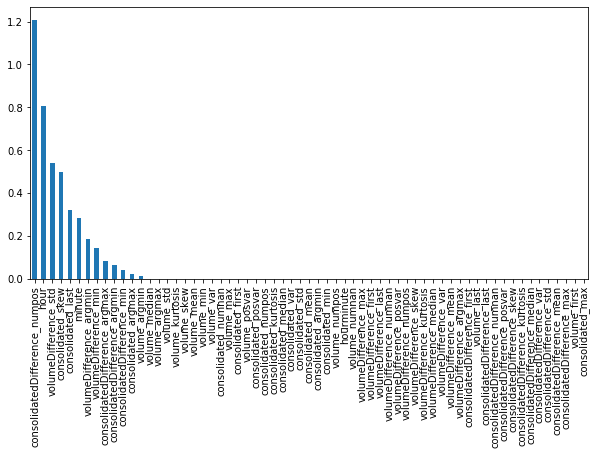

In [20]:
pd.Series(clf.best_estimator_.coef_[0], index=XtrainTrf.columns).abs().sort_values(ascending=False).plot.bar(figsize=(10,5));

# L2 regularization

In [21]:
C = 10**np.linspace(-5,2,100) 
grid_parameters = {
    'C': C,
    'class_weight': [class_weight],
    'penalty':['l2']
}

clf = GridSearchCV(LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=10000, C=C), grid_parameters, scoring='average_precision', cv=3, return_train_score=True)
clf.fit(XtrainTrf, ytrain);  
test_scores = clf.cv_results_['mean_test_score']
train_scores = clf.cv_results_['mean_train_score']
ds = pd.DataFrame({'train_scores':train_scores, 'evaluation_scores':test_scores}, index=C)

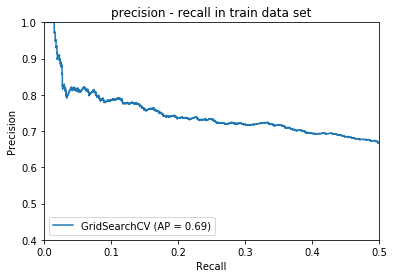

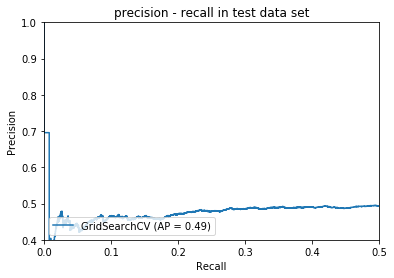

In [22]:
plot_precision_recall_on_train_and_test(clf, XtrainTrf, ytrain, XtestTrf, ytest)

0.6164385638068834
---
consolidatedDifference_var       14.492212
consolidatedDifference_max       13.576289
volume_mean                      11.023581
volumeDifference_max              9.740030
consolidatedDifference_posvar     7.409380
                                   ...    
consolidatedDifference_first      0.052191
consolidatedDifference_argmax     0.041719
volume_argmin                     0.027806
consolidated_argmax               0.020279
volumeDifference_argmax           0.018202
Length: 63, dtype: float64
---
LogisticRegression(C=100.0, class_weight={False: 0.3, True: 0.7}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


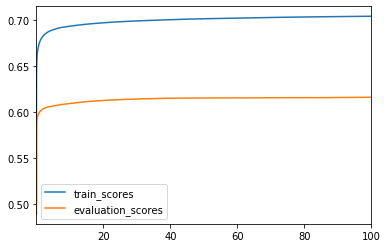

In [23]:
ds.plot()
print(ds.evaluation_scores.max())
print('---')
print(pd.Series(clf.best_estimator_.coef_[0], index=XtrainTrf.columns).abs().sort_values(ascending=False))
print('---')
print(clf.best_estimator_)

# Random Forest
* Horrible overift ... for now! ... unexpectedly hard to control !!

In [ ]:
grid_parameters = {
    #'min_samples_leaf' : [100, 1000, 2000],
    'max_depth': [2, 3, 4, 5, 6, 7, 8,9, 10],
    'n_estimators': [5, 10, 100],   
    'max_features': ['sqrt', 0.1, 0.2, 0.5, 0.8]
}

clf = GridSearchCV(RandomForestClassifier(), grid_parameters, scoring='average_precision', cv=3, return_train_score=True)
clf.fit(XtrainTrf, ytrain);  
test_scores = clf.cv_results_['mean_test_score']
train_scores = clf.cv_results_['mean_train_score']
ds = pd.DataFrame({'train_scores':train_scores, 'evaluation_scores':test_scores})

In [ ]:
plot_precision_recall_on_train_and_test(clf, XtrainTrf, ytrain, XtestTrf, ytest)

In [ ]:
ds.sort_values(by='evaluation_scores', ascending=False).plot.bar(figsize=(15,5))

In [ ]:
clf.best_estimator_

In [ ]:
print("feature importance")
feature_importance = pd.DataFrame({'feature': XtrainTrf.columns, 'importance':clf.best_estimator_.feature_importances_}).set_index('feature').sort_values(by=['importance'], ascending=False)
feature_importance[feature_importance.importance>0].plot.bar(figsize=(15,5))

# Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(XtrainTrf, ytrain); 

In [ ]:
plot_precision_recall_on_train_and_test(clf, XtrainTrf, ytrain, XtestTrf, ytest)